Testing precip filter on month of CPM data //
Jan 2005 //
Threhsold = [240, 200] //
n_min_threshold = [1975, 10]

In [1]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from six.moves import urllib
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import functions
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [2]:
# Import datasets
mask = xr.open_dataset('Save/Mask_Segmentation_tb_precip_test.nc')
mask = mask.segmentation_mask
mask #segmentation mask from tracking on Jan 2005 with [240, 200] and [1975, 10]

precip = xr.open_dataset('/data/users/hgilmour/total_precip/precip_instant/precip_jan_2005.nc')
precip = precip.stratiform_rainfall_flux #precip dataset for Jan 2005 (NEED TO LATER CONVERT FROM KG M-2 S-1 TO MM/HR (X3600))

tracks = pd.read_hdf('Save/Track_precip_test.h5', 'table')

In [3]:
precip

<xarray.DataArray 'stratiform_rainfall_flux' (time: 744, latitude: 1360,
                                              longitude: 1360)>
[1376102400 values with dtype=float32]
Coordinates:
  * time                     (time) datetime64[ns] 2005-01-01T00:30:00 ... 20...
  * latitude                 (latitude) float32 -40.04 -40.0 ... 14.96 15.0
  * longitude                (longitude) float32 275.0 275.0 ... 330.0 330.0
    forecast_period          (time) timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
Attributes:
    standard_name:    stratiform_rainfall_flux
    units:            kg m-2 s-1
    um_stash_source:  m01s04i203
    cell_methods:     time: mean (interval: 1 hour)
    grid_mapping:     latitude_longitude

<xarray.DataArray 'stratiform_rainfall_flux' ()>
array(142.11385, dtype=float32)
Coordinates:
    time                     datetime64[ns] 2005-01-01T08:30:00
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...


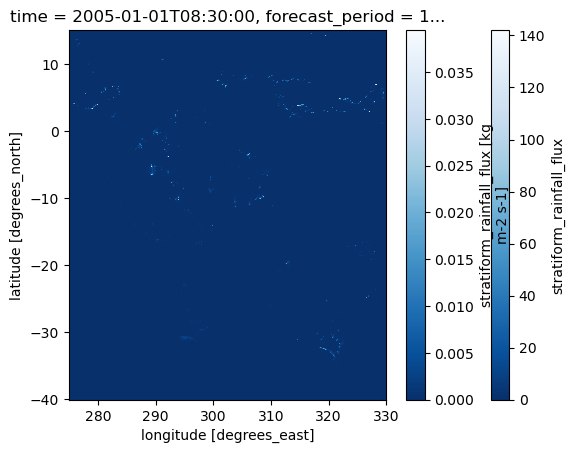

In [4]:
a = precip[8,:,:]*3600
a.plot(cmap='Blues_r')
print(a.max())

precip[8,:,:].plot(cmap='Blues_r')


<xarray.DataArray 'segmentation_mask' (latitude: 1360, longitude: 1360)>
[1849600 values with dtype=int32]
Coordinates:
    time                     datetime64[ns] 2005-01-12T10:30:00
  * latitude                 (latitude) float32 -40.04 -40.0 ... 14.96 15.0
  * longitude                (longitude) float32 275.0 275.0 ... 330.0 330.0
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
Attributes:
    long_name:  segmentation_mask
    units:      1


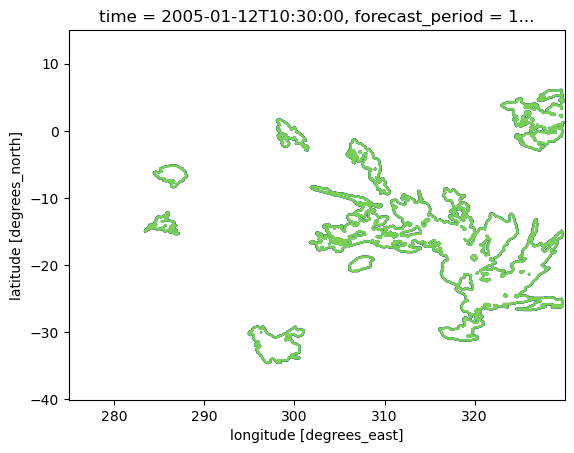

In [5]:
print(mask[274,:,:])
mask[274,:,:].plot.contour()

In [6]:
mask.shape == precip.shape # checking whether the mask and precip files have the same shape
# next steps won't work if not

True

In [7]:
# Copy tracks dataset into new tracks_precip dataset to append precip data to
tracks = tracks.copy()

In [8]:
# Add columns to the tracks_precip dataframe ready to append data to later
tracks['total_precip'] = 0
tracks['rain_flag'] = 0
tracks['convective_precip'] = 0
tracks['heavy_precip'] = 0
tracks['extreme_precip'] = 0

In [15]:
# remove cell values with -1 from tracks dataset
tracks = tracks[tracks.cell >= 0]
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,forecast_reference_time,forecast_period,cell,time_cell,total_precip,rain_flag,convective_precip,heavy_precip,extreme_precip
0,0,9,179.648443,518.713643,3617,240,1,2005-01-01 00:30:00,2005-01-01 00:30:00,-32.764288,-64.032043,295.967957,295.967957,1,0 days 00:00:00,0.000000,0,0.000000,0.000000,0
1,0,26,319.360864,876.726404,7359,240,2,2005-01-01 00:30:00,2005-01-01 00:30:00,-27.105936,-49.532534,310.467466,310.467466,2,0 days 00:00:00,0.000000,0,0.000000,0.000000,0
7,0,274,994.600931,652.721131,3251,240,8,2005-01-01 00:30:00,2005-01-01 00:30:00,0.241288,-58.604738,301.395262,301.395262,8,0 days 00:00:00,7577.864258,904,7426.163086,4816.494629,0
11,0,326,1136.057059,1330.881404,3448,240,12,2005-01-01 00:30:00,2005-01-01 00:30:00,5.970260,-31.139263,328.860737,328.860737,12,0 days 00:00:00,0.000000,0,0.000000,0.000000,0
12,1,7,179.948634,523.925062,4138,240,13,2005-01-01 01:30:00,2005-01-01 01:30:00,-32.752130,-63.820969,296.179031,296.179031,1,0 days 01:00:00,0.000000,0,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9062,742,351,1126.995562,1076.654673,15042,240,9063,2005-01-31 22:30:00,2005-01-31 22:30:00,5.603271,-41.435432,318.564568,318.564568,2222,0 days 08:00:00,0.000000,0,0.000000,0.000000,0
9064,743,28,506.670650,519.857317,40563,240,9065,2005-01-31 23:30:00,2005-01-31 23:30:00,-19.519889,-63.985728,296.014272,296.014272,2193,0 days 15:00:00,0.000000,0,0.000000,0.000000,0
9070,743,97,627.143818,585.244022,13066,240,9071,2005-01-31 23:30:00,2005-01-31 23:30:00,-14.640726,-61.337561,298.662439,298.662439,2218,0 days 10:00:00,0.000000,0,0.000000,0.000000,0
9074,743,208,801.606743,355.515817,3839,240,9075,2005-01-31 23:30:00,2005-01-31 23:30:00,-7.574979,-70.641556,289.358444,289.358444,2233,0 days 06:00:00,0.000000,0,0.000000,0.000000,0


In [16]:
## rainfall thresholds to use within filtering loop ##
precip_threshold = 1 #mm/hr
heavy_precip_threshold = 10 # mm/hr
extreme_precip_threshold = 50 # mm/hr (based on Marengo, J. A., Ambrizzi, T., Alves, L. M., Barreto, N. J., Simões Reboita, M., & Ramos, A. M. (2020). Changing trends in rainfall extremes in the metropolitan area of São Paulo: causes and impacts. Frontiers in Climate, 2, 3.)

precip_area = 25 # threshold for the minimum number of grid points that must be precipitating for a track to remain (and not be dropped from the tracks dataset)


## other parameters that need to be defined before loop ##
s = generate_binary_structure(2,2) # need this in loop later on
removed = 0 # need this for loop later on
precipitation_flag = 0 # creating this for later


## starting precipitation filtering loop ##
for cell in np.unique(tracks.cell.values):
    subset = tracks[tracks.cell == cell]
    precipitation_flag = 0

    for feature in subset.feature.values: #find all the feature values for that unique cell / track (the feature value is a unique value for each feature in a frame /timestep)
        #print(feature)
        for frame in subset.frame[subset.feature == feature]: #find the frame / timestep that corresponds to the feature number
        #  print(frame)
            if mask.shape == precip.shape:
                seg = mask[frame,:,:] #printing the segmentation mask which occurs in the same frame as the feature value
                #print(seg)
                prec = precip[frame,:,:] #printing the precip timesteps which occurs in the same frame as the feature value
                #print(prec)

                featureid = subset.feature[subset.frame == frame].values[0] #find the feature number at each timestep / frame of the cells lifetime (it changes over time and doesn't stay constant)
                #print('featureid: {}'.format(featureid)) #we now know all the feature numbers that belong to a single cell over its lifetime
            
            
                labels, nr = ndimage.label(seg, structure = s) #this line uses ndimage package for image processing. It generates arrays of numbers and decides what are joined together and what aren't.
                # In other words, it does image segmentation tasks, such as finding connected components and labeling objects in an image.
                # (i.e. it generates the locations of all contiguous fields of the segmentation mask that belong to a specific cell at a specific timestep and gives it a label. The number of labels is also recorded (the number of segmented areas in the timestep))

                if featureid not in seg: #check that the feature id number at each timestep is within the segmentation mask, if not, it is ignored and we continue
                    continue
                else:

                    label = np.unique(labels[seg == featureid])[0] #28/07/23: CURRENTLY STUCK ON WHAT THIS LINE IS DOING. START FROM HERE NEXT TIME
                    seg_mask = seg.where(labels == label)
                    #print(seg_mask)

                    #create coordinates from mask
                    seg_mask.coords['mask'] = (('longitude', 'latitude'), seg_mask.data)
                    #print(seg_mask.coords['mask'])
                    #apply mask to precip dataset
                    precip_values = prec.where(seg_mask.coords['mask'].values > 0) # creating a new dataset called 'precip_values' with only the precip values where the seg_mask pixel is labelled as greater than 0 (i.e. the MCS region)
                    #print('precip values: {}'.format(precip_values))
                    array = precip_values.values.flatten() * 3600 # precip values are converted to 1D numpy array and multiplied by 3600 to convert from kg m-2 s-1 to mm / hr
                    values = array[~np.isnan(array)] #removes NaNs from the precip array for further calculations
                    #print(values)

                    total_precip = np.nansum(values[values > 0]) #working out the total precip associated with the mask. First, values of 0 are removed to only consider precipitating pixels. Then np.nansum is used to compute the sum of all precipitating values within the mask.
                    #print('total precip: {}'.format(total_precip))
                    tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip

                    rain_features = values[values >= precip_threshold].shape[0] #number of pixels within the mask that meet the 1 mm/hr precip threshold
                    #print('rain features: {}'.format(rain_features))
                    tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features

                    tracks['convective_precip'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = np.nansum(values[values >= precip_threshold]) #total rain from all pixel where the rainfall threshold of 1 mm/hr is met

                    tracks['heavy_precip'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = np.nansum(values[values >= heavy_precip_threshold]) #total rain from all pixel where the heavy rainfall threshold of 10 mm/hr is met
                    rain_features_heavy = values[values >= heavy_precip_threshold].shape[0] #number of pixels within the mask that meet the heavy rainfall threshold of 10 mm/hr

                    tracks['extreme_precip'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = np.nansum(values[values >= extreme_precip_threshold]) #total rain from all pixel where the extreme rainfall threshold of 50 mm/hr is met
                    rain_features_extreme = values[values >= extreme_precip_threshold].shape[0] #number of pixels within the mask that meet the extreme rainfall threshold of 50 mm/hr
                

                    if rain_features >= precip_area: # if the number of precipitating pixels exceeds the miniumum pixel number... 
                        precipitation_flag += rain_features # add rain pixels to the precipitation flag

    if precipitation_flag == 0: #if the minumum precipitating pixel thresholds aren't met...
        #remove corresponding cell from the tracks dataframe
        tracks = tracks.drop(tracks[tracks.cell == cell].index)
        removed += 1 #print the number of tracks that have been removed from the original dataset

# save precip track files
tracks.to_hdf('Save/Tracks_precip_Jan_2005_test.h5', 'table')





        


featureid: 1


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 13


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 28


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 45


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 59


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 75


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 88


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 102


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 115


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 123


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 133


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 141


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 152


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 160


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 169


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 180


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 191


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 204


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 219


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 239


/var/tmp/ipykernel_120911/438495929.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['total_precip'][(tracks.feature == featureid) & (tracks.frame == frame)  & (tracks.cell == cell)] = total_precip
/var/tmp/ipykernel_120911/438495929.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['rain_flag'][(tracks.feature == featureid) & (tracks.frame == frame) & (tracks.cell == cell)] = rain_features
/var/tmp/ipykernel_120911/438495929.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

featureid: 263


KeyboardInterrupt: 

In [14]:
removed

0

In [13]:
print(tracks[tracks.cell == 8])

     frame  idx       hdim_1      hdim_2   num  threshold_value  feature  \
7        0  274   994.600931  652.721131  3251              240        8   
23       1  246   997.302790  649.673525  3985              240       24   
40       2  207  1000.085394  647.171876  4462              240       41   
53       3  151  1003.611792  643.427105  4439              240       54   
68       4  153  1001.760375  637.916268  3516              240       69   
82       5  161  1002.426140  633.101328  1978              240       83   
97       6  178   999.329845  589.566796  2196              240       98   
110      7  166  1005.332832  573.307600  2083              240      111   

                    time              timestr  latitude  longitude  \
7    2005-01-01 00:30:00  2005-01-01 00:30:00  0.241288 -58.604738   
23   2005-01-01 01:30:00  2005-01-01 01:30:00  0.350713 -58.728157   
40   2005-01-01 02:30:00  2005-01-01 02:30:00  0.463408 -58.829496   
53   2005-01-01 03:30:00  2005-01-0

In [89]:
print(seg_mask.coords)

seg_mask.coords['mask'] = (('longitude', 'latitude'), seg_mask.data)

Coordinates:
    time                     datetime64[ns] 2005-01-01T00:30:00
  * latitude                 (latitude) float32 -40.04 -40.0 ... 14.96 15.0
  * longitude                (longitude) float32 275.0 275.0 ... 330.0 330.0
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...


In [68]:
label = (np.unique(labels[ seg == featureid][0]))

In [69]:
label

array([9], dtype=int32)

<xarray.DataArray 'segmentation_mask' (latitude: 1360, longitude: 1360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time                     datetime64[ns] 2005-01-01T07:30:00
  * latitude                 (latitude) float32 -40.04 -40.0 ... 14.96 15.0
  * longitude                (longitude) float32 275.0 275.0 ... 330.0 330.0
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
Attributes:
    long_name:  segmentation_mask
    units:      1


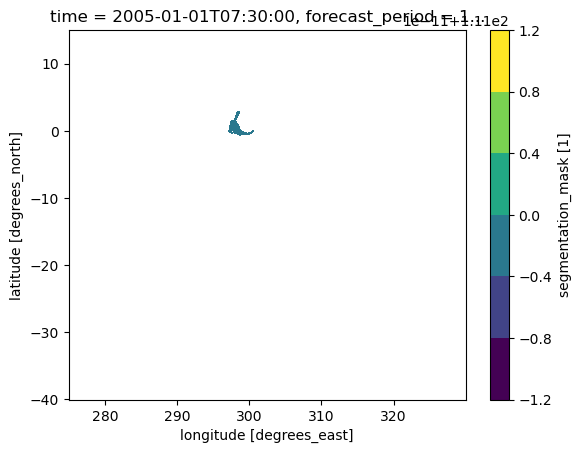

In [77]:
seg_mask = seg.where(labels == label)

print(seg_mask)

seg_mask.plot.contourf()

#np.where(np.isfinite(seg_mask))

In [66]:
subset.timestr[subset.idx == 166]

110    2005-01-01 07:30:00
Name: timestr, dtype: object

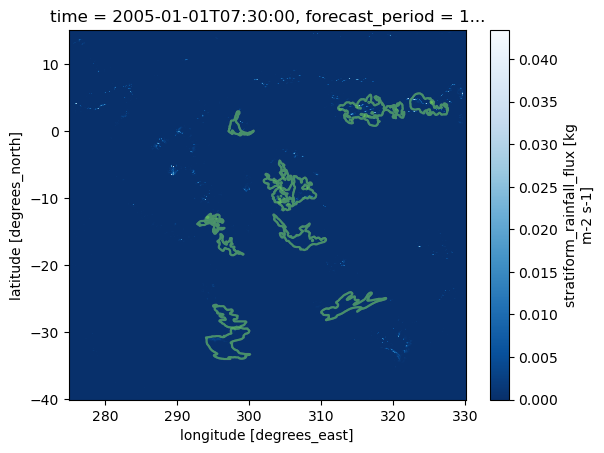

In [95]:
mask[7,:,:].plot.contour(alpha=0.3,zorder=5)
precip[7,:,:].plot(cmap='Blues_r')

In [31]:
print(subset.feature[subset.frame == 111].values[0])
print(subset)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [88]:
nr

16

In [151]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)